# Homework: Simple Spread Trading
Robert Hatem  
APril 16, 2019

## Strategy Overview
* The *simple spread-reversion strategy* bets that the spread on returns for two ETFs will mean-revert. Any deviation of the spread will return to historically "normal" values. 
* When the difference between M-day returns of the two ETFs gets large, the strategy bets that the spread will revert to "normal" levels.
* The strategy uses a buffer zone to avoid too frequent trading. The spread must rise a certain amount before we enter a position. Similarly, the spread must revert a certain amount before we exit the position. This helps avoid too-frequent trading and fees.
* Stop loss mechanisms kick in to exit positions which lose too much money (via failing to mean-revert).

## Results
* The best in-sample return-on-capital found was 0.0006417402. Note this was in-sample; out-of-sample performance will be worse and must be analyzed carefully. This analysis is intended as a starting point for the strategy. If the in-sample ROC is not good enough, then it is not worth investigating further.
* The optimal strategy used the spread on 20-day returns (as opposed to 1-day returns, for example.) The short-term returns fluctuated wildly, more often flipping positions than mean-reverting. 20-day returns, on the other hand, were more stable and showed more steady mean-reversion, and gave the best return-on-capital.
* It should be noted that the capital here was twice the maximum running median of daily trade volumes for *FTSL*. Without analyzing the true costs needed, this seems like an especially large amount of capital needed to run this strategy.

## Data
* Obtain split- and dividend-adjusted closing prices1 for 2 Dec 2016 though 31
Dec 2018 of a pair of ETFs (which we will call X and Y ) as specified below.
* Estimate daily dollar volume, compute the running 15-trading-day median
of it over our sample period for X, and call that running median (as of any
day t) $N_t$.

In [38]:
# upload libraries
library(MASS)
library(Quandl)
library(ggplot2)
library(stringr)
library(R.cache)
library(quantmod)
library(dplyr)
library(zoo)
library(repr)

In [39]:
# memoization
reload.data = TRUE
QLoad <- R.cache::addMemoization(Quandl::Quandl)

In [40]:
# clean col names more
clean.quandl.name <- function(x) {
    cleaned <- x
    if (x=='Date') {
        
    } else {
        tryCatch({
                    parts <- stringr::str_split(x, " - ",n=2)
                    first.parts <- stringr::str_split(parts[[1]][[1]], "\\.",n=2)
                    cleaned <- paste(first.parts[[1]][[2]], parts[[1]][[2]], sep=".")
                    cleaned <- str_replace_all(cleaned," ","")
                    },
                 error = function(e) {cat(paste0("Err on",x,"\n"))}
                 )
    }
    stringr::str_trim(cleaned)
}

Make one function to upload, clean, and prepare the data.  

Finds data on two ETFs from the _EOD_ database from Quandl.

In [41]:
# prepare data
UploadData = function(ticker1, ticker2) {
    # get data
    Quandl.api_key('wFcUAbwJv3FbxzDwExsY')  # my key
    cat("Data Reload/n")
    quandl.call.1 = paste('EOD/', ticker1, '.11', sep='')
    quandl.call.2 = paste('EOD/', ticker1, '.12', sep='')
    quandl.call.3 = paste('EOD/', ticker2, '.11', sep='')
    quandl.call.4 = paste('EOD/', ticker2, '.12', sep='')
    
    # call Quandl
    data.raw.1 <- QLoad(c(quandl.call.1, quandl.call.2), start_date="2016-12-02", end_date="2018-12-31")
    data.raw.2 <- QLoad(c(quandl.call.3, quandl.call.4), start_date="2016-12-02", end_date="2018-12-31")
    
    # daily dollar volume
    new_col_name_1 = paste(ticker1, '.Daily_Volume', sep='')
    new_col_name_2 = paste(ticker2, '.Daily_Volume', sep='')
    
    data.raw.1[new_col_name_1] = data.raw.1[,2] * data.raw.1[,3]
    data.raw.2[new_col_name_2] = data.raw.2[,2] * data.raw.2[,3]
    
    # running median
    new_col_name_1 = paste(ticker1, '.Running_Median', sep='')
    #new_col_name_2 = paste(ticker2, '.Running_Median', sep='')
    
    data.raw.1[new_col_name_1] = c(rep(NA,14), rollmedian(data.raw.1[,4], 15))
    #data.raw.2[new_col_name_2] = c(rep(NA,14), rollmedian(data.raw.2[,4], 15))
        
    # clean col names
    names(data.raw.1) <- paste(cat("EOD.", ticker1, " -", sep=""), names(data.raw.1))  # add prefix
    names(data.raw.2) <- paste(cat("EOD.", ticker2, " -", sep=""), names(data.raw.2))
    names(data.raw.1)[1] <-"Date"  # remove one prefix
    names(data.raw.2)[1] <-"Date"   # remove one prefix
    raw_data = merge(data.raw.1, data.raw.2)  # combine, one dataframe
    
    # clean col names again
    fixed.names <- lapply(names(raw_data), clean.quandl.name)
    cat(paste(fixed.names,sep="\n"))
    renamed_data <- raw_data
    names(renamed_data) <- fixed.names
    
    return(renamed_data)
}

In [42]:
# upload data
df = UploadData('FTSL', 'SMH')

Data Reload/nEOD.FTSL -EOD.SMH -Err on FTSL.Daily_Volume
Err on FTSL.Running_Median
Err on SMH.Daily_Volume
Date FTSL.Adj_Close FTSL.Adj_Volume FTSL.Daily_Volume FTSL.Running_Median SMH.Adj_Close SMH.Adj_Volume SMH.Daily_Volume

In [43]:
# show the data
head(df)

Date,FTSL.Adj_Close,FTSL.Adj_Volume,FTSL.Daily_Volume,FTSL.Running_Median,SMH.Adj_Close,SMH.Adj_Volume,SMH.Daily_Volume
2016-12-02,43.99145,261604,11508339,NA,66.38097,3795973,251980355
2016-12-05,44.07356,232060,10227710,NA,67.04700,2654097,177949231
2016-12-06,44.11917,185084,8165753,NA,67.78059,2682705,181835338
2016-12-07,44.20128,293449,12970822,NA,69.13196,3463480,239437156
2016-12-08,44.20128,285315,12611289,NA,69.54702,2530952,176020171
2016-12-09,44.20128,111049,4908508,NA,69.18987,3411178,236018977


## Description
The two ETFs used were *FTSL* and *SMH*:
* **FTSL**: The First Trust Senior Loan Fund is an actively managed exchange-traded fund. The fund invests primarily in first lien senior floating-rate bank loans ("Senior Loans"). The fund's secondary investment objective is the preservation of capital. Under normal market conditions, the fund will invest in at least 80% of its net assets in Senior Loans that are made predominantly to businesses operating in North America and may also invest up to 20% of its net assets in non-Senior Loan debt securities, warrants, equity securities and securities of other investment companies.
*  **SMH**: VanEck Vectors® Semiconductor ETF (SMH®) seeks to replicate companies involved in semiconductor production and equipment.

## Spread-Reversion Strategy
* The strategy bets that the spread between returns of the two ETFs will revert back to its average level whenever it deviates. We assume the average spread is zero, since these ETFs usually have similar returns. On any given day, the returns of one is higher than the other, but on average they are almost identical.
* It's possible that *SMH* has higher mean returns but larger variance than *FTSL* since it replicates stocks while *FTSL* replicates loans. If so, we might exepct *SMH* to drive fluctuations of the spread. Regardless, the strategy is agnostic as to which ETF caused the deviation; it simply bets that the spread will revert to normal.

## Parameters
The strategy depends on **four parameters**:
  1. **g**: The threshold the spread must deviate from zero to enter a position (-g for below zero). g needs to be large enough to indicate deviation that should revert to the mean, but small enough to enter enough positions to profit from during reversion.
  2. **j**: The threshold to exit a position. g and j create a no-trade band which avoid frequent trading and fees. To small a band, the strategy will trade very often and collect large fees, but will have many small profits when reversion happens. Too large a band, and the strategy will have fewer larger profits, and avoid frequent trading and fees.  
  3. **s**: The percentage of the gross traded cash needed to enter a position that the position must lose to trigger a stop loss. The stop loss immediately exits the position and ceases trading until the next month. Too large a stop loss, and a position could continue losing value as the spread continues to deviate. Too small a stop loss, and the strategy will exit positions before reversion can happen.
  4. **m**: Used to calculate the m-day returns, then used to calculate the spread. For larger windows (large m), we expect the returns and the spread to stabilize, giving fewer trading opportunities.
  
The four parameters will be tuned using *grid search* below.

In [44]:
# simple spread strategy 

SimpleSpread = function(df, g=0.2, j=0.1, s=0.1, M=1) {
    # Runs spread stragegy and calculates PnL.
    #
    # Args:
    #   df: dataframe with two ticker's data.
    #   g: upper bound for entering positions.
    #   j: lower bound for learving position
    #   s: stop loss parameter. Proportion s of the gross traded cast for which if present position value
    #      has lost more than, then force an exit at current prices, and assume no more new positions for
    #      the remainder of the month.
    #   M: the window for calculating returns. Gives M-day returns (from adj. closing price). 
    #
    # Returns:
    #   df.temp: the dataframe with orders, positions, and PnL.
    
    df.temp = df
    
    # M-day Returns
    df.temp['FTSL.Returns'] = Delt( df.temp[, c('FTSL.Adj_Close')], k=M )
    df.temp['SMH.Returns'] = Delt( df.temp[, c('SMH.Adj_Close')], k=M )
    
    # Spread
    df.temp$Spread = df.temp[,c('FTSL.Returns')] - df.temp[,c('SMH.Returns')]
    
    # initialize new columns
    new_col_names = c('Position.X', 'Position.Y', 'Num.shares.X', 'Num.shares.Y','cashflow.X', 'cashflow.Y', 'Gross.traded.cash', 'cashflow.total', 'Position.value', 'Stop.loss.ind')
    for (new_col in new_col_names) {
        df.temp[new_col] = 0  }
    
    new_col_names2 = c('Final.position', 'Order')
    for (new_col in new_col_names2) {
        df.temp[new_col] = NA  }
    
    # stop loss
    stop.loss = 0
    
    # initialize new positoins
    new.position.X = 0
    new.position.Y = 0
    
    for (row in 1:nrow(df.temp)){
        # start trading Jan 2017
        if (format(df.temp$Date[row], format="%y") < 17) {
            next
        }
        
        
        if (format(df.temp$Date[row], format="%m") != format(df.temp$Date[row-1], format="%m")){    # if first day of month
            stop.loss = 0    # reset stop loss
        }
               
        if (stop.loss == 0) {    # if the stop loss is off

            if (df.temp$Spread[row] > g) {    # ends above g, so be short the spread (-1,1)
                new.position.X = -1
                new.position.Y = 1

            } else if (df.temp$Spread[row] < -g) {    # ends below -g, so be long the spread (1,-1)
                new.position.X = 1
                new.position.Y = -1

            } else if ((df.temp$Spread[row] > -j) & (df.temp$Spread[row] < g) & (df.temp$Position.X[row-1] == 1)) {    # was in long position but lands above -j
                new.position.X = 0
                new.position.Y = 0

            } else if ((df.temp$Spread[row] > -g) & (df.temp$Spread[row] < j) & (df.temp$Position.X[row-1] == -1)) {    # was in short position but lands below j
                new.position.X = 0
                new.position.Y = 0

            } else {} # keep new.positions.X (Y) from prior row

            # last day of dataset or last day of month
            if ((row == nrow(df.temp)) | (format(df.temp$Date[row+1], format="%m") != format(df.temp$Date[row], format="%m"))) {
                new.position.X = 0
                new.position.Y = 0  }  # close positions

        } else if (stop.loss == 1) {
            new.position.X = 0
            new.position.Y = 0    # positions should be closed 
        }  
    
        stop.loss.repeat = 0
        while (stop.loss.repeat == 0) {  
        
            # record positions
            df.temp$Position.X[row] = new.position.X
            df.temp$Position.Y[row] = new.position.Y

            # if position changed
            if ((df.temp$Position.X[row] != df.temp$Position.X[row-1]) & (df.temp$Position.X[row] != df.temp$Position.X[row-1])) {    # need to change position
                # Number of shares needed to be in that position
                df.temp$Num.shares.X[row] =  df.temp$Position.X[row] * floor( df.temp$FTSL.Running_Median[row] / ( 100*df.temp$FTSL.Adj_Close[row]) )
                df.temp$Num.shares.Y[row] =  df.temp$Position.Y[row] * floor( df.temp$FTSL.Running_Median[row] / ( 100*df.temp$SMH.Adj_Close[row]) )
            } else {    # maintain current number of shares
                df.temp$Num.shares.X[row] = df.temp$Num.shares.X[row-1]
                df.temp$Num.shares.Y[row] = df.temp$Num.shares.Y[row-1]  }


            # cashflow to enter that position
            df.temp$cashflow.X[row] = -1 * ( df.temp$Num.shares.X[row] - df.temp$Num.shares.X[row-1] ) * df.temp$FTSL.Adj_Close[row]
            df.temp$cashflow.Y[row] = -1 * ( df.temp$Num.shares.Y[row] - df.temp$Num.shares.Y[row-1] ) * df.temp$SMH.Adj_Close[row]

            df.temp$cashflow.total[row] = df.temp$cashflow.X[row] + df.temp$cashflow.Y[row]

            # gross traded cash
            df.temp$Gross.traded.cash[row] = abs(df.temp$cashflow.X[row]) + abs(df.temp$cashflow.Y[row])
            if (df.temp$Gross.traded.cash[row] == 0){
                df.temp$Gross.traded.cash[row] = df.temp$Gross.traded.cash[row-1]  }

            # position value
            df.temp$Position.value[row] = (df.temp$Num.shares.X[row] * df.temp$FTSL.Adj_Close[row]) + (df.temp$Num.shares.Y[row] * df.temp$SMH.Adj_Close[row])

            # order (for plotting)
            if (df.temp$Position.X[row] - df.temp$Position.X[row-1] > 0) {
                df.temp$Order[row] = "Buy the spread"    # buy the spread
                if (df.temp$Position.X[row] == 1) {    # be long the spread
                    df.temp$Final.position[row] = "1"
                } else if (df.temp$Position.X[row] == 0) {
                    df.temp$Final.position[row] = "0"  }

            } else if (df.temp$Position.X[row] - df.temp$Position.X[row-1] < 0) {
                df.temp$Order[row] = "Sell the spread"    # go short spread (sell)
                if (df.temp$Position.X[row] == -1) {
                    df.temp$Final.position[row] = "1"
                } else if (df.temp$Position.X[row] == 0) {
                    df.temp$Final.position[row] = "0"  }

            } else { df.temp$Order[row] = NA }

            # check for stop loss
            if ((df.temp$Position.X[row] == 0) & (df.temp$Position.Y[row] == 0)){
                #print(paste('Row:', row,'| Date:', df.temp$Date[row], '| In no position'))
                stop.loss.repeat = 1    # don't need to check for stop loss if we have no position
            } else if ((df.temp$Position.X[row-1] == 0) & (df.temp$Position.Y[row-1] == 0)) {
                #print(paste('Row:', row,'| Date:', df.temp$Date[row], '| Just enetered position'))
                stop.loss.repeat = 1
            } else if ((df.temp$Position.value[row] - df.temp$Position.value[row-1]) < -s*df.temp$Gross.traded.cash[row]) {    # stop loss
                #print(paste('Row:', row, '| Date:', df.temp$Date[row], '| Position value change:', df.temp$Position.value[row] - df.temp$Position.value[row-1], 'Stop loss threshold:', -s*df.temp$Gross.traded.cash[row], '| Triggered!'))
                new.position.X = 0
                new.position.Y = 0    # close positions
                stop.loss = 1    # turn on stop loss, and recalculate with closed positions
                df.temp$Stop.loss.ind[row] = 1
            } else {
                #print(paste('Row:', row, '| Date:', df.temp$Date[row], '| Position value change:', df.temp$Position.value[row] - df.temp$Position.value[row-1], 'Stop loss threshold:', -s*df.temp$Gross.traded.cash[row]))
                stop.loss.repeat = 1    # done, end the while loop
            }
        }
    }
    
    # profit and loss
    df.temp$PnL = cumsum(df.temp$cashflow.total)
    
    # change to factor for easy plotting
    #df.temp$Order = as.factor(df.temp$Order)
    
    # return on capital
    capital = 2*max(df.temp$FTSL.Running_Median, na.rm=TRUE)
    roc = tail(df.temp$PnL, 1)/capital
    
    # final result (named list)
    result <- list(df=df.temp, roc=roc)
    
    return(result)
}


## Analysis

### Grid search of parameters
* **g**: evenly spaced from just above 0 to 0.16. This was found to be roughly the maximum observed spread (depends on m) in our dataset.
* **j**: fraction of g (e.g. 0.1, 0.5, 0.8) to ensure it's above zero but lower than g
* **s**: fraction (0 to 1). Goes by powers of ten, starting with 1e-6.
* **m**: Set of values from 1 to 20 days (1,2,5,20). 20 days is maximum based on the data we have (trading starts Jan 1, 2017 and our data goes back one month prior, i.e. 20 trading days).

In [45]:
# g values evenly spaced from 0 to max spread, removing first value since it's zero
g_vals = seq(0, 0.16, length.out=10)[2:10]

# j multipliers
j_mults = seq(0.1, 0.9, length.out=5)

# s values
s_vals = 10^seq(-6,-2, length.out=3)

# m values
m_vals = c(1,5,20)

In [46]:
# initialize
param_df = data.frame(g=0, j=0, s=0, m=0, max_spread=0, roc=0)

n = 1

# grid search
for (g_val in g_vals){    # g sampled uniformaly from 0 to max of the spread
    for (j_val in g_val*j_mults) {   # make j below g, by certain fraction amounts
        for (s in s_vals) {
            for (m in m_vals) {
                result = SimpleSpread(df, g=g_val, j=j_val, s=s, M=m)
                param_df[n,] = list(g=g_val, j=j_val, s=s, m=m, max_spread=max(result[['df']]$Spread, na.rm=TRUE), roc=result[['roc']])
                n = n + 1
            }
        }
    }
}

In [47]:
print('Optimal parameters:')
param_df[which.max(param_df$roc),]

[1] "Optimal parameters:"


,g,j,s,m,max_spread,roc
99,0.05333333,0.005333333,0.01,20,0.1682487,0.0006417402


In [48]:
# optimal parameters
g_opt = param_df[which.max(param_df$roc),]$g
j_opt = param_df[which.max(param_df$roc),]$j
s_opt = param_df[which.max(param_df$roc),]$s
m_opt = param_df[which.max(param_df$roc),]$m

In [49]:
# run with optimal parameters
result1 = SimpleSpread(df, g=g_opt, j=j_opt, s=s_opt, M=m_opt)

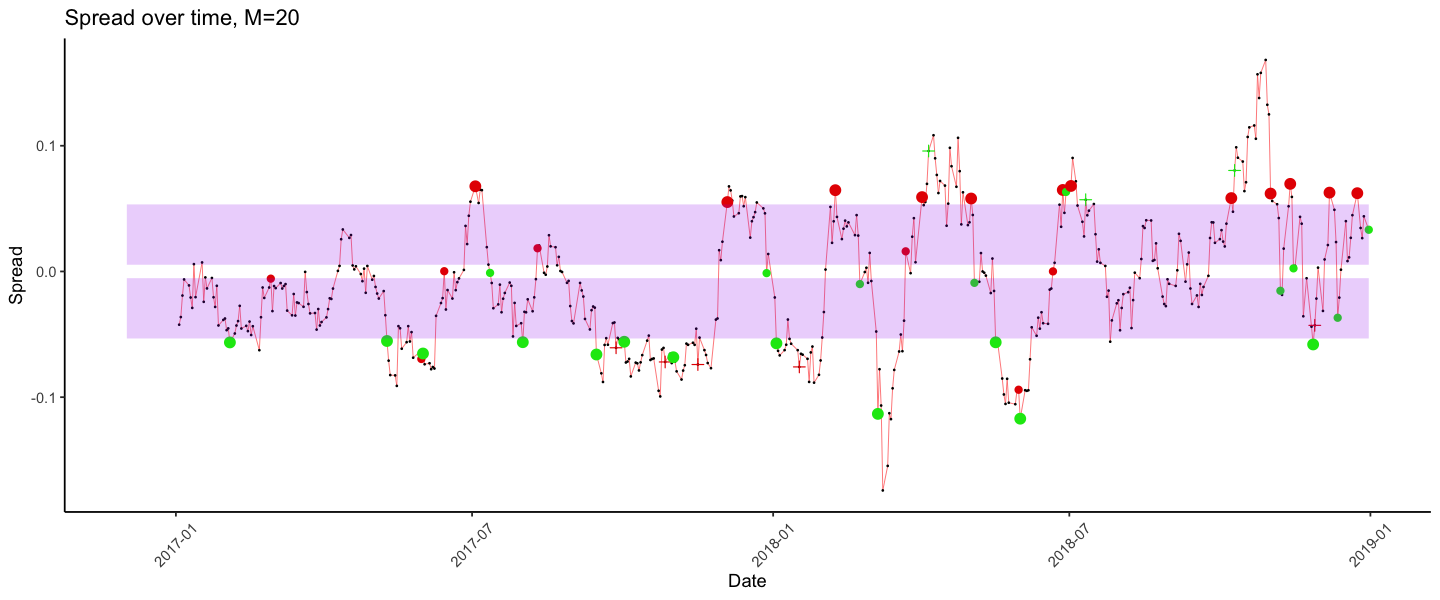

In [51]:
start = 1
end = 522

options(repr.plot.width=12, repr.plot.height=5)


df1 = result1[['df']]

# plot
gp <- ggplot(data=df1[start:end,], aes(x=Date)) +
    geom_line(aes(y=Spread), color='red', size=0.15, na.rm=TRUE)  +
    geom_point(aes(y=Spread), shape=19, color='black', size=0.1, na.rm=TRUE) +
    
    geom_point(aes(y=Spread, colour=Order, size=Final.position, shape=as.factor(Stop.loss.ind)), na.rm=TRUE) +
    scale_color_manual(values=c("Buy the spread" = "#00e613", "Sell the spread" = "#e61300", "#56B4E9", "#56B4E9")) +
    scale_size_manual(values=c(2,3)) +
    scale_shape_manual(values=c(16,3)) +
    
    geom_ribbon(aes(ymin=j_opt, ymax=g_opt, alpha=0.1), fill="purple", alpha = 0.2, show.legend = F) +
    geom_ribbon(aes(ymin=-g_opt, ymax=-j_opt, alpha=0.1), fill="purple", alpha = 0.2, show.legend = F) +
    #geom_hline(yintercept=s, linetype="dashed", color = "black", size=0.3) +
    #geom_hline(yintercept=-s, linetype="dashed", color = "black", size=0.3) +
    ggtitle("Spread over time, M=20") +
    theme(axis.text.x = element_text(angle = 45, vjust=0.5),  # rotate x axis text
          panel.grid.minor = element_blank(),
          legend.position = "none",
          panel.grid.major = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))
    

#ggsave(file="pnl.pdf", width=8, height=4, dpi=300)

print(gp)


cols = names(df1)[c(1,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24)]
#df1[start:end,cols]

# Check M=1

In [35]:
# check the best m=1
d = param_df %>% filter(m == 1)
d[which.max(d$roc),]
g_opt = d[which.max(d$roc),]$g
j_opt = d[which.max(d$roc),]$j
s_opt = d[which.max(d$roc),]$s
m_opt = d[which.max(d$roc),]$m

,g,j,s,m,max_spread,roc
10,0.03555556,0.003555556,1e-06,1,0.06586376,0.0002850871


In [36]:
# run with optimal parameters
result1 = SimpleSpread(df, g=g_opt, j=j_opt, s=s_opt, M=m_opt)

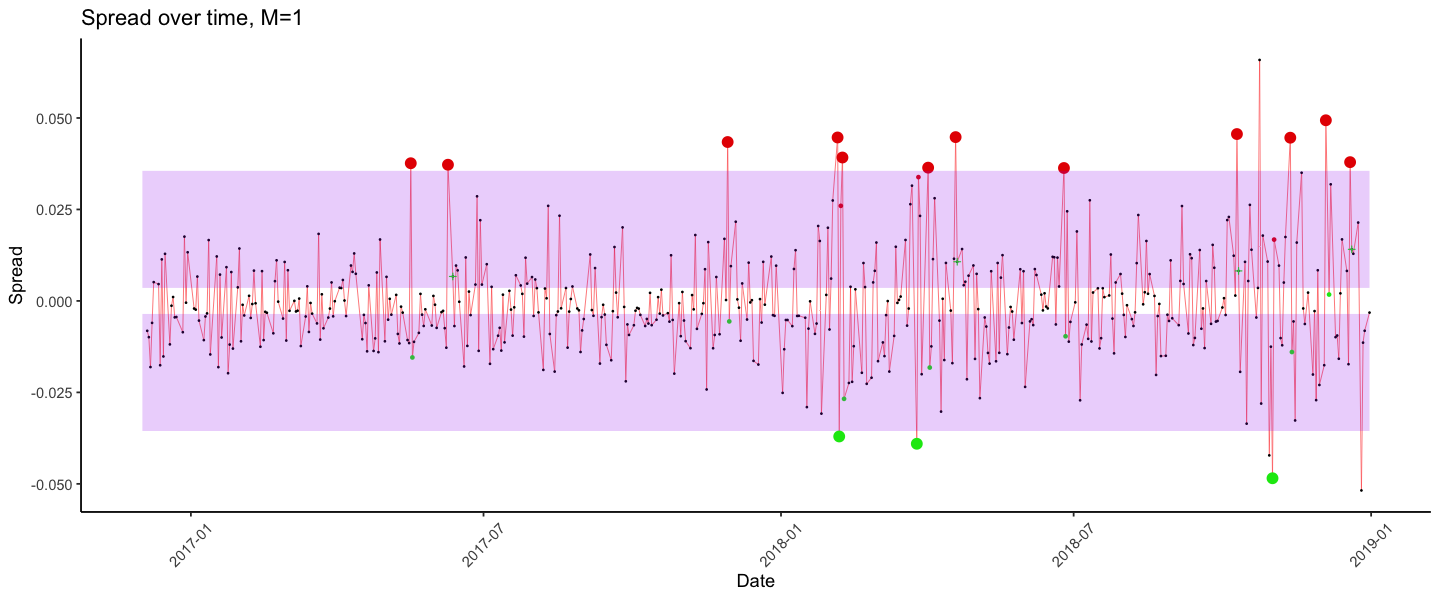

In [37]:
start = 1
end = 522

options(repr.plot.width=12, repr.plot.height=5)


df1 = result1[['df']]

# plot
gp <- ggplot(data=df1[start:end,], aes(x=Date)) +
    geom_line(aes(y=Spread), color='red', size=0.15, na.rm=TRUE)  +
    geom_point(aes(y=Spread), shape=19, color='black', size=0.1, na.rm=TRUE) +
    
    geom_point(aes(y=Spread, colour=Order, size=Final.position, shape=as.factor(Stop.loss.ind)), na.rm=TRUE) +
    scale_color_manual(values=c("Buy the spread" = "#00e613", "Sell the spread" = "#e61300", "#56B4E9", "#56B4E9")) +
    scale_size_manual(values=c(1,3)) +
    scale_shape_manual(values=c(16,3)) +
    
    geom_ribbon(aes(ymin=j_opt, ymax=g_opt, alpha=0.1), fill="purple", alpha = 0.2, show.legend = F) +
    geom_ribbon(aes(ymin=-g_opt, ymax=-j_opt, alpha=0.1), fill="purple", alpha = 0.2, show.legend = F) +
    #geom_hline(yintercept=s, linetype="dashed", color = "black", size=0.3) +
    #geom_hline(yintercept=-s, linetype="dashed", color = "black", size=0.3) +
    ggtitle("Spread over time, M=1") +
    theme(axis.text.x = element_text(angle = 45, vjust=0.5),  # rotate x axis text
          panel.grid.minor = element_blank(),
          legend.position = "none",
          panel.grid.major = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))
    

#ggsave(file="pnl.pdf", width=8, height=4, dpi=300)

print(gp)


cols = names(df1)[c(1,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24)]
#df1[start:end,cols]

The prices flucuate so wildly that the position is more likely to flip rather than mean-revert.